In [ ]:
import os, sys
import warnings


warnings.filterwarnings(
    "ignore", category=UserWarning, module="torchvision.io.image", lineno=13
)
warnings.filterwarnings(
    "ignore",
    message="The installed version of bitsandbytes was compiled without GPU support.*",
    category=UserWarning,
    module='bitsandbytes.cextension'
)
warnings.filterwarnings("ignore")
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message="This implementation of AdamW is deprecated",
)

os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["NUMEXPR_MAX_THREADS"] = "28"
os.environ["ENABLE_SDP_FUSION"] = "true"
os.environ["SYCL_PI_LEVEL_ZERO_USE_IMMEDIATE_COMMANDLISTS"]="1"

In [1]:
from datasets import load_dataset
import torch
device = torch.device("cpu")
emotions = load_dataset("dair-ai/emotion",download_mode='force_redownload')

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [3]:
from collections import defaultdict

def count_class_distribution(dataset):
    class_counts = defaultdict(int)
    for example in dataset:
        class_counts[example['label']] += 1
    return class_counts


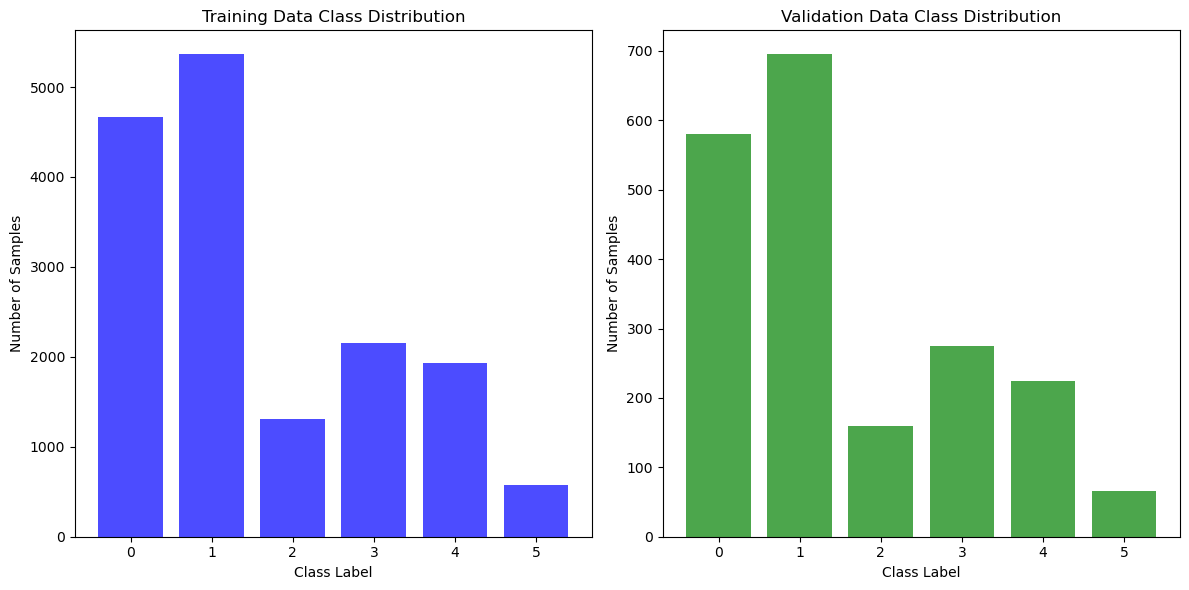

In [4]:
from collections import defaultdict
import matplotlib.pyplot as plt

# Now you can use count_class_distribution()


    
train_data = emotions['train']
val_data = emotions['test']
# Calculate class distributions
train_class_distribution = count_class_distribution(train_data)
val_class_distribution = count_class_distribution(val_data)
            
# Get class labels and counts for training and validation data
train_labels, train_counts = zip(*train_class_distribution.items())
val_labels, val_counts = zip(*val_class_distribution.items())
            
# Plotting the distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
            
ax1.bar(train_labels, train_counts, color='blue', alpha=0.7)
ax1.set_title('Training Data Class Distribution')
ax1.set_xlabel('Class Label')
ax1.set_ylabel('Number of Samples')
            
ax2.bar(val_labels, val_counts, color='green', alpha=0.7)
ax2.set_title('Validation Data Class Distribution')
ax2.set_xlabel('Class Label')
ax2.set_ylabel('Number of Samples')
            
plt.tight_layout()
plt.show()

In [6]:
from transformers import AutoTokenizer

model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)


def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [7]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [6]:
from transformers import AutoModelForSequenceClassification
num_labels = 6
model = (AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
emotions_encoded["train"].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [8]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
emotions_encoded["train"].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [9]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
training_args = TrainingArguments(output_dir="results",
                                  num_train_epochs=4,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1",
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  save_strategy="epoch",
                                  disable_tqdm=False,
                                  report_to=[])

In [11]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"])
trainer.train();

/home/u13a42d3044c46ca14f13d1e647346b9/.local/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: aten::layer_norm: an autograd kernel was not registered to the Autograd key(s) but we are trying to backprop through it. This may lead to silently incorrect behavior. This behavior is deprecated and will be removed in a future version of PyTorch. If your operator is differentiable, please ensure you have registered an autograd kernel to the correct Autograd key (e.g. DispatchKey::Autograd, DispatchKey::CompositeImplicitAutograd). If your operator is not differentiable, or to squash this warning and use the previous behavior, please register torch::CppFunction::makeFallthrough() to DispatchKey::Autograd. (Triggered internally at ../torch/csrc/autograd/autograd_not_implemented_fallback.cpp:63.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.262967,0.913500,0.914666
2,0.512500,0.167350,0.932000,0.931811
3,0.512500,0.152609,0.936500,0.936615
4,0.110400,0.147945,0.933000,0.932898


/home/u13a42d3044c46ca14f13d1e647346b9/.local/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: aten::layer_norm: an autograd kernel was not registered to the Autograd key(s) but we are trying to backprop through it. This may lead to silently incorrect behavior. This behavior is deprecated and will be removed in a future version of PyTorch. If your operator is differentiable, please ensure you have registered an autograd kernel to the correct Autograd key (e.g. DispatchKey::Autograd, DispatchKey::CompositeImplicitAutograd). If your operator is not differentiable, or to squash this warning and use the previous behavior, please register torch::CppFunction::makeFallthrough() to DispatchKey::Autograd. (Triggered internally at ../torch/csrc/autograd/autograd_not_implemented_fallback.cpp:63.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/u13a42d3044c46ca14f13d1e647346b9/.local/lib/python3.9/site-packages/torc

In [12]:
results = trainer.evaluate() #without lora 0.935
results

{'eval_loss': 0.15260876715183258,
 'eval_accuracy': 0.9365,
 'eval_f1': 0.9366152171269541,
 'eval_runtime': 6.1946,
 'eval_samples_per_second': 322.864,
 'eval_steps_per_second': 5.166,
 'epoch': 4.0}

In [13]:
preds_output = trainer.predict(emotions_encoded["test"])
preds_output.metrics #without lora 0.935

{'test_loss': 0.1798877865076065,
 'test_accuracy': 0.9215,
 'test_f1': 0.9219729256431618,
 'test_runtime': 5.9595,
 'test_samples_per_second': 335.599,
 'test_steps_per_second': 5.37}

In [17]:
model.save_pretrained('./f11_model')
tokenizer.save_pretrained('./f11_model')

('./f11_model/tokenizer_config.json',
 './f11_model/special_tokens_map.json',
 './f11_model/vocab.txt',
 './f11_model/added_tokens.json',
 './f11_model/tokenizer.json')